In [1]:
!git clone https://github.com/gdg-raipur/paper-reading.git

Cloning into 'paper-reading'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 20 (delta 5), reused 14 (delta 3), pack-reused 0
Unpacking objects: 100% (20/20), 8.89 KiB | 1.48 MiB/s, done.


In [2]:
%cd paper-reading
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
!tar xf imagenette2-320.tgz

/content/paper-reading
--2023-03-25 15:11:51--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.136.248, 52.217.100.190, 54.231.138.216, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.136.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341663724 (326M) [application/x-tar]
Saving to: ‘imagenette2-320.tgz’

imagenette2-320.tgz 100%[===================>] 325.83M  89.9MB/s    in 3.8s    

2023-03-25 15:11:55 (85.0 MB/s) - ‘imagenette2-320.tgz’ saved [341663724/341663724]



In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def find_lr(model, train_loader, criterion, device, optimizer, init_lr=1e-8, final_lr=10, beta=0.98):
    model.train()
    num_batches = len(train_loader)
    mult = (final_lr / init_lr) ** (1 / num_batches)
    lr = init_lr
    optimizer.param_groups[0]['lr'] = lr

    avg_loss = 0.0
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []

    for inputs, labels in tqdm(train_loader, desc="Finding Learning Rate"):
        batch_num += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute the smoothed loss
        avg_loss = beta * avg_loss + (1 - beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta ** batch_num)

        # Update the learning rate
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr

        # Record the loss and learning rate
        losses.append(smoothed_loss)
        log_lrs.append(np.log10(lr))

        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            break

        if smoothed_loss < best_loss or batch_num == 1:
            best_loss = smoothed_loss

    return log_lrs, losses

# Train the model
def train(model, dataloader, optimizer, criterion, device, scheduler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if scheduler:
            scheduler.step()

    return running_loss / len(dataloader), correct / total


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / len(dataloader), correct / total
  
def visualize_kernels(model):
    # Get the weights of the first convolutional layer
    # first_conv_layer = model.features[0]
    kernels = model.conv1[0].weight.detach().cpu().numpy()

    # Normalize the weights to be between 0 and 1
    min_val = kernels.min()
    max_val = kernels.max()
    normalized_kernels = (kernels - min_val) / (max_val - min_val)

    # Plot the kernels
    num_kernels = normalized_kernels.shape[0]
    num_columns = 8
    num_rows = num_kernels // num_columns + int(num_kernels % num_columns > 0)
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))

    for i, ax in enumerate(axes.flat):
        if i < num_kernels:
            kernel_img = normalized_kernels[i, :, :, :].transpose(1, 2, 0)
            ax.imshow(kernel_img)
        ax.axis("off")

    plt.show()

In [ ]:


# Define data transforms for training and validation datasets
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the data using a DataLoader
train_set = ImageFolder('./imagenette2-320/train', transform=train_transform)
val_set = ImageFolder('./imagenette2-320/val', transform=val_transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=4)


# Define the model and move to device
model = VGG13(num_classes=10)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define cyclic learning rate schedule
max_lr = 0.01
base_lr = 0.001
step_size = len(train_loader) * 2
# clr = optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=step_size)



In [ ]:
import numpy as np

# Run the learning rate finder
log_lrs, losses = find_lr(model, train_loader, criterion, device, optimizer)

# Plot the learning rate vs. loss
plt.figure()
plt.plot(log_lrs, losses)
plt.xlabel("Log10 Learning Rate")
plt.ylabel("Smoothed Loss")
plt.title("Learning Rate vs. Loss")
plt.show()


In [ ]:
from week_1.vgg13 import VGG13
from week_1.vgg13 import VGG13
from week_1.vgg13 import VGG13

In [ ]:
import numpy as np


# Run the learning rate finder
log_lrs, losses = find_lr(model, train_loader, criterion, device, optimizer)

# Plot the learning rate vs. loss
plt.figure()
plt.plot(log_lrs, losses)
plt.xlabel("Log10 Learning Rate")
plt.ylabel("Smoothed Loss")
plt.title("Learning Rate vs. Loss")
plt.show()


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define data transforms for training and validation datasets
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the data using a DataLoader
train_set = ImageFolder('./imagenette2-320/train', transform=train_transform)
val_set = ImageFolder('./imagenette2-320/val', transform=val_transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=4)


# Define the model and move to device
model = VGG13(num_classes=10)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define cyclic learning rate schedule
max_lr = 0.01
base_lr = 0.001
step_size = len(train_loader) * 2
# clr = optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=step_size)






Validation: 100%|██████████| 123/123 [00:22<00:00,  5.56it/s]


Epoch 1, Train Loss: 1.2484, Train Acc: 0.5968, Val Loss: 1.0027, Val Acc: 0.6698


Validation: 100%|██████████| 123/123 [00:23<00:00,  5.28it/s]


Epoch 2, Train Loss: 1.2323, Train Acc: 0.6046, Val Loss: 0.9261, Val Acc: 0.6986


Validation: 100%|██████████| 123/123 [00:23<00:00,  5.22it/s]


Epoch 3, Train Loss: 1.1803, Train Acc: 0.6173, Val Loss: 0.8675, Val Acc: 0.7208


Validation: 100%|██████████| 123/123 [00:24<00:00,  5.00it/s]


Epoch 4, Train Loss: 1.1622, Train Acc: 0.6252, Val Loss: 0.9091, Val Acc: 0.7039


Validation: 100%|██████████| 123/123 [00:24<00:00,  5.04it/s]


Epoch 5, Train Loss: 1.1512, Train Acc: 0.6314, Val Loss: 0.8573, Val Acc: 0.7192


Validation: 100%|██████████| 123/123 [00:24<00:00,  5.04it/s]


Epoch 6, Train Loss: 1.1249, Train Acc: 0.6414, Val Loss: 0.9511, Val Acc: 0.6856


Validation: 100%|██████████| 123/123 [00:23<00:00,  5.25it/s]


Epoch 7, Train Loss: 1.1057, Train Acc: 0.6425, Val Loss: 0.8524, Val Acc: 0.7241


Validation: 100%|██████████| 123/123 [00:23<00:00,  5.30it/s]


Epoch 8, Train Loss: 1.0922, Train Acc: 0.6508, Val Loss: 0.7419, Val Acc: 0.7580


Validation: 100%|██████████| 123/123 [00:23<00:00,  5.15it/s]


Epoch 9, Train Loss: 1.0589, Train Acc: 0.6612, Val Loss: 0.7767, Val Acc: 0.7468


Validation: 100%|██████████| 123/123 [00:24<00:00,  5.01it/s]


Epoch 10, Train Loss: 1.0470, Train Acc: 0.6628, Val Loss: 0.7831, Val Acc: 0.7406


Validation: 100%|██████████| 123/123 [00:24<00:00,  5.06it/s]


Epoch 11, Train Loss: 1.0147, Train Acc: 0.6786, Val Loss: 0.7198, Val Acc: 0.7623


Validation: 100%|██████████| 123/123 [00:24<00:00,  4.98it/s]


Epoch 12, Train Loss: 0.9845, Train Acc: 0.6843, Val Loss: 0.7625, Val Acc: 0.7475


Validation: 100%|██████████| 123/123 [00:23<00:00,  5.24it/s]


Epoch 13, Train Loss: 0.9720, Train Acc: 0.6892, Val Loss: 0.7276, Val Acc: 0.7694


Validation: 100%|██████████| 123/123 [00:22<00:00,  5.35it/s]


Epoch 14, Train Loss: 0.9463, Train Acc: 0.6984, Val Loss: 0.7140, Val Acc: 0.7679


Validation: 100%|██████████| 123/123 [00:22<00:00,  5.39it/s]


Epoch 15, Train Loss: 0.9153, Train Acc: 0.7102, Val Loss: 0.7565, Val Acc: 0.7501


Validation: 100%|██████████| 123/123 [00:23<00:00,  5.31it/s]


Epoch 16, Train Loss: 0.9040, Train Acc: 0.7204, Val Loss: 0.7073, Val Acc: 0.7676


Validation: 100%|██████████| 123/123 [00:23<00:00,  5.14it/s]


Epoch 17, Train Loss: 0.9195, Train Acc: 0.7108, Val Loss: 0.7108, Val Acc: 0.7753


Validation: 100%|██████████| 123/123 [00:24<00:00,  5.11it/s]


Epoch 18, Train Loss: 0.8812, Train Acc: 0.7252, Val Loss: 0.6397, Val Acc: 0.7911


Validation: 100%|██████████| 123/123 [00:24<00:00,  5.10it/s]


Epoch 19, Train Loss: 0.8920, Train Acc: 0.7252, Val Loss: 0.6966, Val Acc: 0.7817


Validation: 100%|██████████| 123/123 [00:23<00:00,  5.21it/s]


Epoch 20, Train Loss: 0.8606, Train Acc: 0.7291, Val Loss: 0.6328, Val Acc: 0.8023


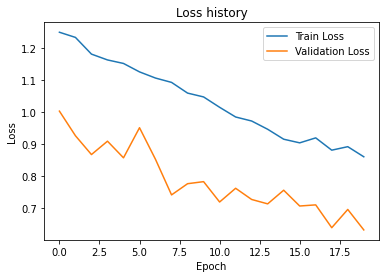

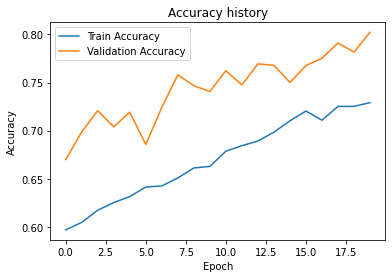

In [ ]:


# Main training and validation loop
num_epochs = 20
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

# Plotting the training and validation loss
plt.figure()
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure()
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy history")
plt.legend()
plt.show()

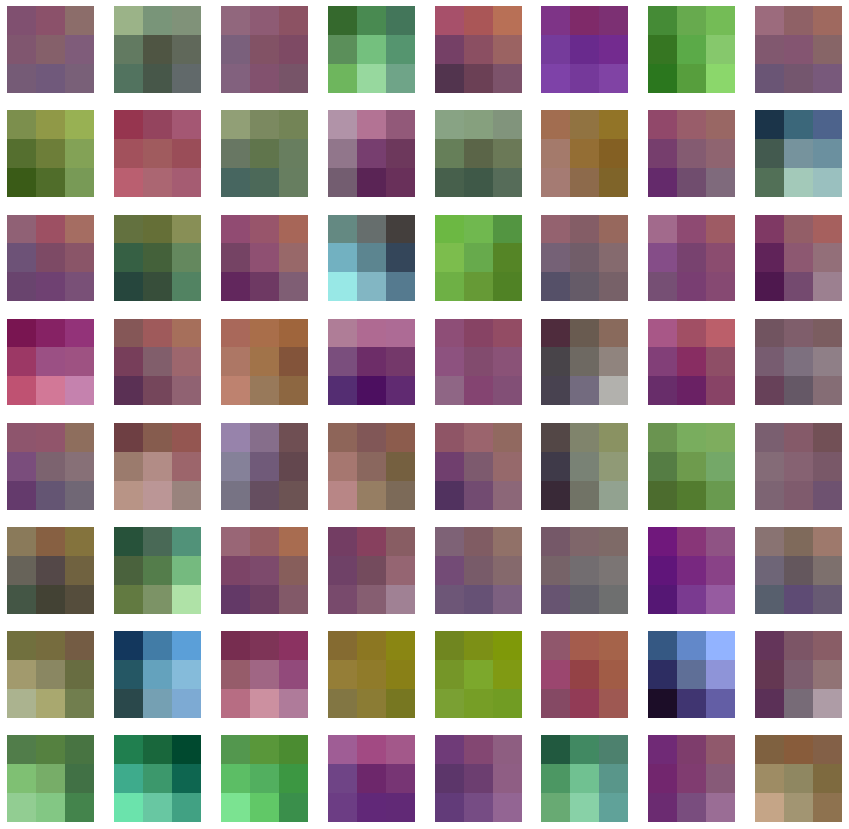

In [ ]:
visualize_kernels(model)


In [ ]:
# Get the weights of the first Conv2d layer in the conv5 block
weights = model.conv1[0].weight.detach().cpu()

In [ ]:
import matplotlib.pyplot as plt

def plot_kernels(tensor, num_cols=8):
    num_kernels = tensor.shape[0]
    num_rows = 1 + num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols, num_rows))
    
    for i in range(num_kernels):
        ax1 = fig.add_subplot(num_rows, num_cols, i + 1)
        ax1.imshow(tensor[i][0], cmap='gray')  # Visualize the first channel of the kernel
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


In [ ]:
weights = model.conv1[0].weight.detach().cpu()

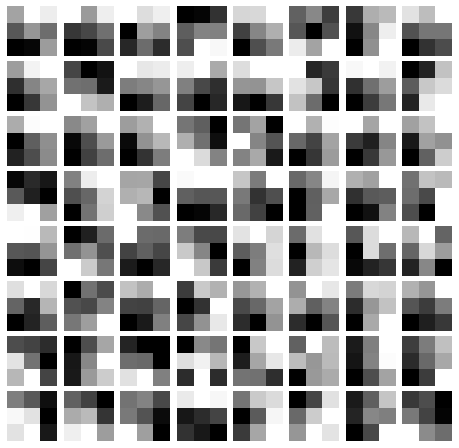

In [ ]:
# Normalize the weights for visualization
normalized_weights = (weights - weights.min()) / (weights.max() - weights.min())

# Visualize the kernels of the first Conv2d layer in the conv5 block
plot_kernels(normalized_weights)


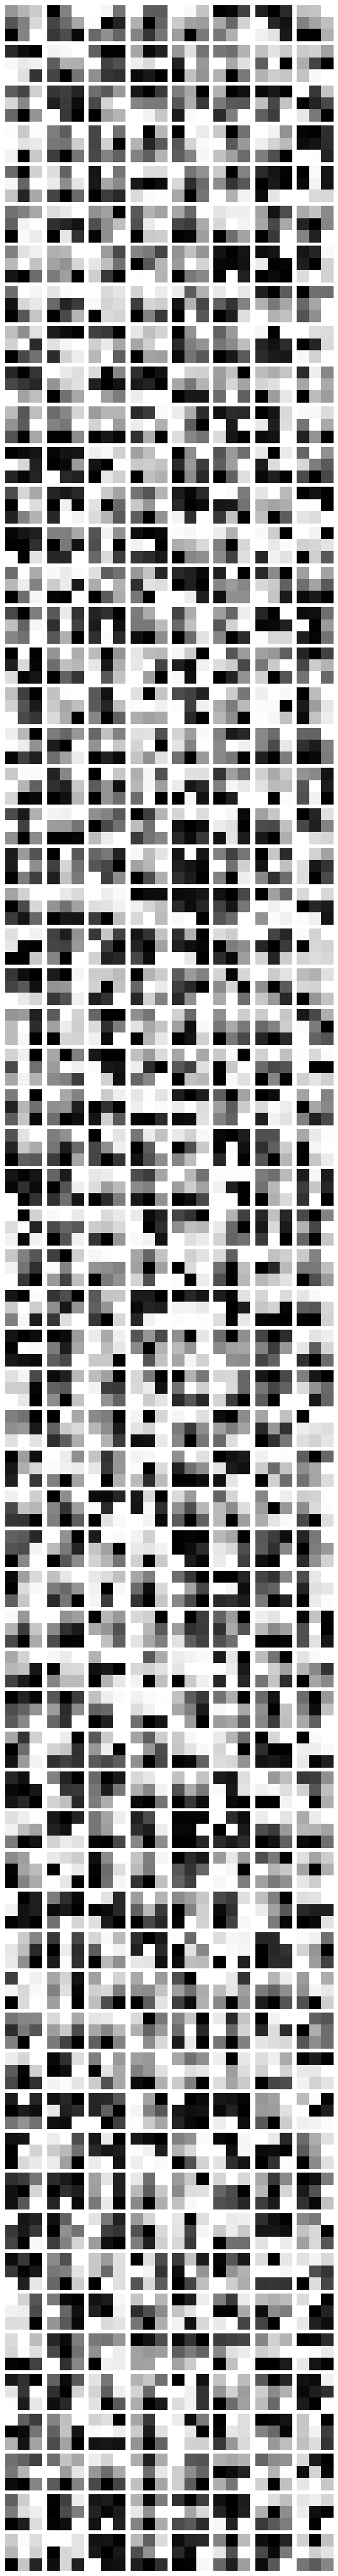

In [ ]:
weights = model.conv5[0].weight.detach().cpu()

# Normalize the weights for visualization
normalized_weights = (weights - weights.min()) / (weights.max() - weights.min())

# Visualize the kernels of the first Conv2d layer in the conv5 block
plot_kernels(normalized_weights)
